# Simple consumption-saving problem

**Table of contents**<a id='toc0_'></a>    
- 1. [Imports](#toc1_)    
- 2. [Model](#toc2_)    
- 3. [Defining the model class](#toc3_)    
  - 3.1. [Setup and allocate](#toc3_1_)    
  - 3.2. [Drawing shocks and initial states](#toc3_2_)    
  - 3.3. [Quadrature](#toc3_3_)    
  - 3.4. [Outcomes](#toc3_4_)    
  - 3.5. [Reward](#toc3_5_)    
  - 3.6. [Transition functions](#toc3_6_)    
  - 3.7. [Terminal actions](#toc3_7_)    
- 4. [DeepSimulate](#toc4_)    
- 5. [DeepVPD](#toc5_)    
- 6. [DeepFOC](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Imports](#toc0_)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # without this Python may crash when plotting from matplotlib
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [2]:
from consav.quadrature import log_normal_gauss_hermite

In [3]:
import EconDLSolvers

## 2. <a id='toc2_'></a>[Model](#toc0_)

We are going to solve a **simple consumption-saving model**.

1. A single state: cash-on-hand $m_t$
2. A single transitory shock $\psi_t \sim \log \mathcal{N}\left(-\frac{1}{2}\sigma_{\psi}^2,\sigma_{\psi}^2\right) \\$ 
3. A single choice: consumption $c_t$, or equivalently the savings rate, $a_t\in[0,1]$

The utility function is

$$
u(c_t) = \log (c_t)
$$

The bellman equation is

$$
\begin{aligned}
v_t(m_t) &= \underset{a_t\in[0,1]}{\max} \ u(c_t) + \beta E_t[v_{t+1}(m_{t+1})] \\
&\text{s.t} \\
c_t &= a_t m_t\\ 
\bar{m}_t &= m_t - c_t \\ 
m_{t+1} &= (1+r) \bar{m}_t + \kappa \cdot \psi_{t+1} \\
\end{aligned}
$$

**Solve with three different methods:**

1. DeepSimulate
2. DeepVPD
3. DeepFOC

## 3. <a id='toc3_'></a>[Defining the model class](#toc0_)

First define the model class based on the **DLSolverclass** from the package.

In [4]:
class Model(EconDLSolvers.DLSolverClass): # inherit from DLSolverClass

    # setup and allocate
    def setup(self): pass
    def allocate(self): pass
    def setup_train(self): pass
    def allocate_train(self): pass

    # draw
    def draw_initial_states(self): pass
    def draw_shocks(self): pass

    # transition
    def outcomes(self): pass # states, actions -> (intermediary) outcomes
    def state_trans_pd(self): pass # states, actions, outcomes -> post-decision states
    def state_trans(self): pass # post-decision states, shocks -> next-period states
    def terminal_actions(self): pass # action in last period = zero savings rate = consume everything

    # reward
    def reward(self): pass # utility
    terminal_reward_pd = EconDLSolvers.terminal_reward_pd # defaults to just 0
    discount_factor = EconDLSolvers.discount_factor # default to just par.beta

    # exploration (not used in DeepSimulate)
    draw_exploration_shocks = EconDLSolvers.draw_exploration_shocks # default is normal(0,epsilon_sigma)
    exploration = EconDLSolvers.exploration # default is action + eps (clipping is also imposed)

    # FOC (only used in DeepFOC)
    def eval_equations_FOC(self): pass

### 3.1. <a id='toc3_1_'></a>[Setup and allocate](#toc0_)

In [5]:
def setup(model):
    """ choose parameters """

    # a. unpack
    par = model.par
    sim = model.sim

    par.seed = 1 # seed for random number generator

    # b. model
    par.T = 3 # number of periods

    # preferences
    par.beta = 1.0/1.04 # discount factor
    
    # income process
    par.kappa = 0.2 # income scale
    par.sigma_psi = 0.3 # shock, std

    # assets
    par.r = 0.02 # return rate

    # initial states
    par.mu_m0 = 1.0 # initial cash-on-hand, mean
    par.sigma_m0 = 0.1 # initial cash-on-hand, std

    # c. simulation
    sim.N = 10_000 # number of agents

    # d. misc

    # states
    par.Nstates = 1 # number of states
    par.Nstates_pd = 1 # number of states, post decision

    # number of actions and outcomes
    par.Nactions = 1 # number of actions
    par.Noutcomes = 1 # will be consumption in our case

    # number of shocks
    par.Nshocks = 1 # psi is the only shock
    par.Npsi = 4 # number of quadrature points - not used in DeepSimulate

Model.setup = setup

In [6]:
def allocate(model):
    """ allocate arrays  """

    # unpack
    par = model.par
    sim = model.sim
    train = model.train
    dtype = train.dtype
    device = train.device        

    # a. quadrature (not used in DeepSimulate)
    par.psi,par.psi_w = log_normal_gauss_hermite(par.sigma_psi,par.Npsi)
    par.psi = torch.tensor(par.psi,dtype=dtype,device=device) # convert to tensor
    par.psi_w = torch.tensor(par.psi_w,dtype=dtype,device=device) # convert to tensor

    # b. simulation (same across models)
    sim.states = torch.zeros((par.T,sim.N,par.Nstates),dtype=dtype,device=device) # State-vector
    sim.states_pd = torch.zeros((par.T,sim.N,par.Nstates_pd),dtype=dtype,device=device) # post-decision state vector
    sim.shocks = torch.zeros((par.T,sim.N,par.Nshocks),dtype=dtype,device=device) # Shock-vector
    sim.outcomes = torch.zeros((par.T,sim.N,par.Noutcomes),dtype=dtype,device=device) # outcomes array
    sim.actions = torch.zeros((par.T,sim.N,par.Nactions),dtype=dtype,device=device)  # actions array
    sim.reward = torch.zeros((par.T,sim.N),dtype=dtype,device=device) # array for utility rewards

    sim.R = np.nan # initialize average discounted utility

Model.allocate = allocate

In [7]:
def setup_train(model):
    """ default parameters for training """
    
    par = model.par
    train = model.train
    dtype = train.dtype
    device = train.device

    # a. neural network
    train.Nneurons_policy = np.array([50,50]) # number of neurons in hidden layers
    train.Nneurons_value = np.array([50,50]) # number of neurons in hidden layers (only used in DeepVPD)
    
    # b. policy activation functions and clipping
    train.policy_activation_final = ['sigmoid'] # action is savings rate in [0,1]
    
    train.min_actions = torch.tensor([0.0 for _ in range(par.Nactions)],dtype=dtype,device=device) # minimum action value
    train.max_actions = torch.tensor([0.9999 for _ in range(par.Nactions)],dtype=dtype,device=device) # maximum action value		
    
    # c. exploration (not used in DeepSimulate)
    train.epsilon_sigma = np.array([0.05])
    train.epsilon_sigma_decay = 1.0 # decay rate for epsilon_sigma
    train.epsilon_sigma_min = np.array([0.0]) # minimum value for epsilon if decay is used

    # d. misc
    train.terminal_actions_known = True # not used in DeepSimulate
    train.only_time_termination = True
    train.K_time = 0.5 # run time in minutes

Model.setup_train = setup_train

In [8]:
def allocate_train(model):
    """ allocate memory training """

    par = model.par
    train = model.train
    dtype = train.dtype
    device = train.device

    # a. training samples (same across models)
    train.states = torch.zeros((par.T,train.N,par.Nstates),dtype=dtype,device=device)
    train.states_pd = torch.zeros((par.T,train.N,par.Nstates_pd),dtype=dtype,device=device)
    train.shocks = torch.zeros((par.T,train.N,par.Nshocks),dtype=dtype,device=device)
    train.outcomes = torch.zeros((par.T,train.N,par.Noutcomes),dtype=dtype,device=device)
    train.actions = torch.zeros((par.T,train.N,par.Nactions),dtype=dtype,device=device)
    train.reward = torch.zeros((par.T,train.N),dtype=dtype,device=device)

Model.allocate_train = allocate_train

### 3.2. <a id='toc3_2_'></a>[Drawing shocks and initial states](#toc0_)

In [9]:
def draw_initial_states(model,N,training=False):
    """ draw initial state (m,p,t) """

    # a. unpack
    par = model.par
    sigma_m0 = par.sigma_m0

    # b. draw cash-on-hand
    m0 = par.mu_m0*np.exp(torch.normal(-0.5*sigma_m0**2,sigma_m0,size=(N,)))
 
    # c. store
    return torch.stack((m0,),dim=1) # (N,Nstates)

def draw_shocks(model,N):
    """ draw shocks """

    par = model.par

    psi_loc = -0.5*par.sigma_psi**2
    psi = np.exp(torch.normal(psi_loc,par.sigma_psi,size=(par.T,N,)))

    return torch.stack((psi,),dim=-1) # (T,N,Nshocks)

Model.draw_initial_states = draw_initial_states
Model.draw_shocks = draw_shocks

### 3.3. <a id='toc3_3_'></a>[Quadrature](#toc0_)

In [10]:
def quad(model): # not used in DeepSimulate
    """ quadrature nodes and weights """

    # a. unpack
    par = model.par
    psi = par.psi
    psi_w = par.psi_w

    # b. quadrature nodes and weights
    quad = torch.stack((psi,),dim=1) # (Npsi,1)
    quad_w = psi_w # (Npsi,)

    return quad,quad_w
    
Model.quad = quad

### 3.4. <a id='toc3_4_'></a>[Outcomes](#toc0_)

In [11]:
def outcomes(model,states,actions,t0=0,t=None):
	""" outcomes """

	m = states[...,0]
	a = actions[...,0]
	c = m*(1-a) # intermediary outcome, not a state or action, but still useful

	return torch.stack((c,),dim=-1) # (T,N,Noutcomes)

Model.outcomes = outcomes

### 3.5. <a id='toc3_5_'></a>[Reward](#toc0_)

In [12]:
def utility(par,c):
	""" utility """

	return torch.log(c)

def reward(model,states,actions,outcomes,t0=0,t=None):
	""" reward """

	# a. unpack
	par = model.par

	# b. consumption
	c = outcomes[...,0]

	# c. utility
	u = utility(par,c)

	return u 

Model.reward = reward

### 3.6. <a id='toc3_6_'></a>[Transition functions](#toc0_)

$$
\bar{m}_t=m_t-c_t
$$

In [13]:
def state_trans_pd(model,states,actions,outcomes,t0=0,t=None):
	""" transition to post-decision state """

	# Case I: t is None -> t in t0,...,t0+T-1 <= par.T-1:
	#  states.shape = (T,...,Nstates)
	#  actions.shape = (T,...,Nactions)
	#  outcomes.shape = (T,...,Noutcomes)

	# Case II: t in 0,...,T-1, t0 irrelevant:
	#  states.shape = (N,Nstates)
	#  actions.shape = (N,Nactions)
	#  outcomes.shape = (N,Noutcomes)

	# DeepSimulate: never t == None

	# this model: does not depend on t
	
	# a. unpack
	par = model.par

	# b. get cash-on-hand and consumption
	m = states[...,0]
	c = outcomes[...,0]

	# c. post-decision
	m_pd = m-c

	# d. finalize
	states_pd = torch.stack((m_pd,),dim=-1)
	return states_pd
	# Case I: shape = (T,...,Nstates_pd)
	# Case II: shape = (N,Nstates_pd)

Model.state_trans_pd = state_trans_pd

$$
m_{t+1}=(1+r)\bar{m}_t + \kappa\psi_{t+1}
$$

In [14]:
def state_trans(model,states_pd,shocks,t=None):
	""" state transition with quadrature """

	# Case I: t is None -> t in 0,...,T-1 <= par.T-1:
	#  states_pd.shape = (T,N,Nstates_pd)
	#  shocks.shape = (Nquad,Nshocks) [this is quadrature nodes]
	
	# Case II: t in 0,...,T-1, t0 irrelevant:
	#  states_pd.shape = (N,Nstates_pd)
	#  shocks.shape = (N,Nshocks) [this is actual shocks]

	# DeepSimulate: never t == None

	# a. unpack
	par = model.par
	train = model.train

	# b. get post-decision cash-on-hand and shock
	m_pd = states_pd[...,0]
	psi = shocks[:,0]

	if t is None:
		m_pd = EconDLSolvers.expand_to_quad(m_pd,train.Nquad) # (T,N) ==> (T,N,Nquad) Nquad = number of quadrature nodes
		psi = EconDLSolvers.expand_to_states(psi,states_pd) # (Nquad,) ==> (T,N,Nquad)

	# c. future cash-on-hand
	m_plus = (1+par.r)*m_pd + psi*par.kappa
	
	# d. finalize
	states_plus = torch.stack((m_plus,),dim=-1) # (T,N,1)	
	return states_plus
	# Case I: shape = (T,N,Nquad,Nstates)
	# Case II: shape = (N,Nstates)

Model.state_trans = state_trans

### 3.7. <a id='toc3_7_'></a>[Terminal actions](#toc0_)

In [15]:
def terminal_actions(model,states):
	""" terminal actions """

	# Case I: states.shape = (1,...,Nstates)
	# Case II: states.shape = (N,Nstates)
	
	par = model.par
	train = model.train
	dtype = train.dtype
	device = train.device
	
	actions = torch.zeros((*states.shape[:-1],1),dtype=dtype,device=device)

	if train.algoname == 'DeepFOC':
		multipliers = torch.zeros((*states.shape[:-1],1),dtype=dtype,device=device)
		actions = torch.cat((actions,multipliers),dim=-1)

	return actions 
	# Case I: shape = (1,...,Nactions)
	# Case II: shape = (N,Nactions)	

Model.terminal_actions = terminal_actions

## 4. <a id='toc4_'></a>[DeepSimulate](#toc0_)

In [16]:
model_DeepSimulate = Model(algoname='DeepSimulate',device='cpu')

In [17]:
model_DeepSimulate.solve(do_print=True)

started solving: 2025-01-21 15:59:32
k =     0 of inf: sim.R =  -2.24872303 [best:  -2.24872303] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.00 mins]
k =    50 of inf: sim.R =  -2.18541551 [best:  -2.18541551] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.01 mins]
k =   100 of inf: sim.R =  -2.18470907 [best:  -2.18470907] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.03 mins]
k =   150 of inf: sim.R =  -2.18436527 [best:  -2.18436527] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.04 mins]
k =   200 of inf: sim.R =  -2.18410087 [best:  -2.18410087] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.06 mins]
k =   250 of inf: sim.R =  -2.18389869 [best:  -2.18389869] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.07 mins]
k =   300 of inf: sim.R =  -2.18384480 [best:  -2.18384480] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.08 mins]
k =   350 of inf: sim.R =  -2.18383431 [best:  -2.18383431] [0.0 se

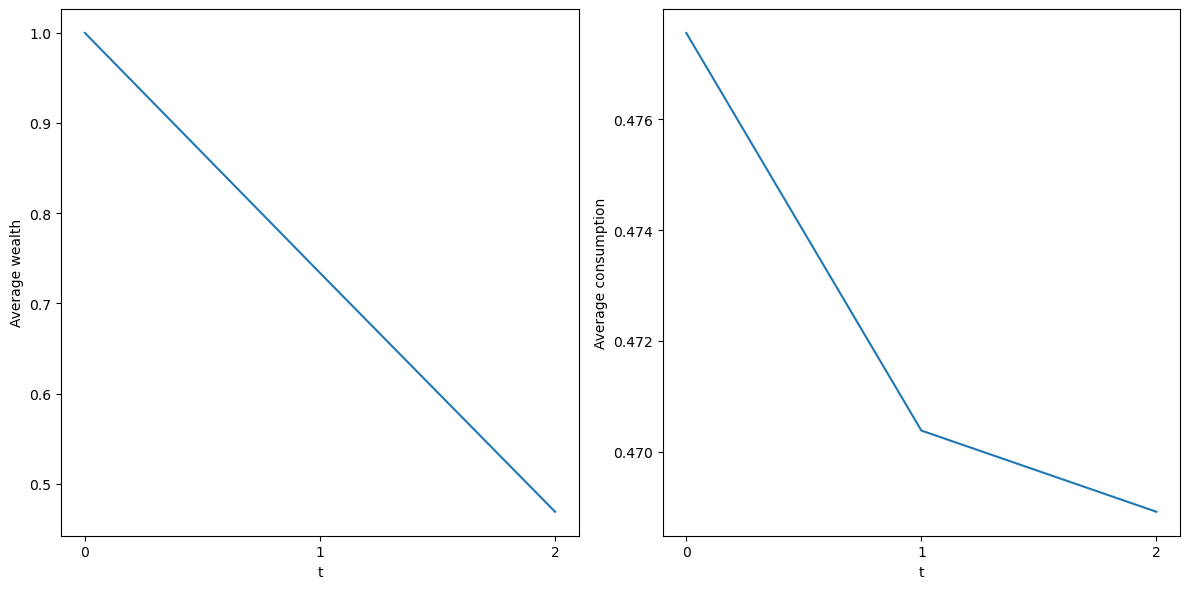

In [18]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

t_range = range(model_DeepSimulate.par.T)
avg_wealth_DeepSimulate = model_DeepSimulate.sim.states[...,0].mean(dim=1).cpu().numpy()
avg_consumption_DeepSimulate = model_DeepSimulate.sim.outcomes[...,0].mean(dim=1).cpu().numpy()

ax[0].plot(t_range,avg_wealth_DeepSimulate,label='Average wealth')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Average wealth')
ax[0].set_xticks(t_range)

ax[1].plot(t_range,avg_consumption_DeepSimulate,label='Average consumption')
ax[1].set_xlabel('t')
ax[1].set_ylabel('Average consumption')
ax[1].set_xticks(t_range)

fig.tight_layout()

## 5. <a id='toc5_'></a>[DeepVPD](#toc0_)


In [19]:
model_DeepVPD = Model(algoname='DeepVPD',device='cpu')

In [20]:
model_DeepVPD.solve(do_print=True)

started solving: 2025-01-21 16:00:03
k =     0 of inf: sim.R =  -2.25577664 [best:  -2.25577664] [0.2 secs] [value_epochs =  50] [policy_epochs =   0] [  0.00 mins]
k =    10 of inf: sim.R =  -2.21996260 [best:  -2.21996260] [0.3 secs] [value_epochs =  50] [policy_epochs =  15] [  0.03 mins]
k =    20 of inf: sim.R =  -2.18448997 [best:  -2.18448997] [0.2 secs] [value_epochs =  50] [policy_epochs =  15] [  0.07 mins]
k =    30 of inf: sim.R =  -2.18410110 [best:  -2.18410110] [0.3 secs] [value_epochs =  50] [policy_epochs =  15] [  0.11 mins]
k =    40 of inf: sim.R =  -2.18429351 [best:  -2.18410110] [0.3 secs] [value_epochs =  50] [policy_epochs =  15] [  0.15 mins] no improvements in 0.0 mins
k =    50 of inf: sim.R =  -2.18442845 [best:  -2.18410110] [0.2 secs] [value_epochs =  50] [policy_epochs =   6] [  0.18 mins] no improvements in 0.1 mins
k =    60 of inf: sim.R =  -2.18400764 [best:  -2.18400764] [0.2 secs] [value_epochs =  50] [policy_epochs =  15] [  0.22 mins]
k =    70 o

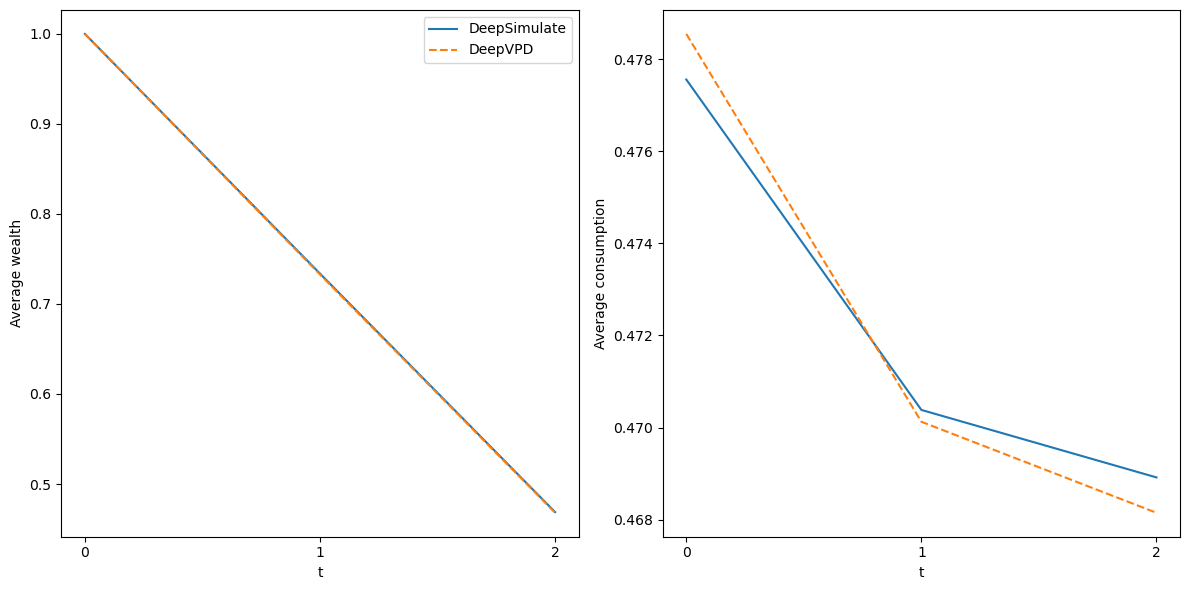

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

t_range = range(model_DeepVPD.par.T)
avg_wealth_DeepVPD = model_DeepVPD.sim.states[...,0].mean(dim=1).cpu().numpy()
avg_consumption_DeepVPD = model_DeepVPD.sim.outcomes[...,0].mean(dim=1).cpu().numpy()

ax[0].plot(t_range,avg_wealth_DeepSimulate,label='DeepSimulate')
ax[0].plot(t_range,avg_wealth_DeepVPD,label='DeepVPD',linestyle='--')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Average wealth')
ax[0].set_xticks(t_range)
ax[0].legend()

ax[1].plot(t_range,avg_consumption_DeepSimulate,label='DeepSimulate')
ax[1].plot(t_range,avg_consumption_DeepVPD,label='DeepVPD',linestyle='--')
ax[1].set_xlabel('t')
ax[1].set_ylabel('Average consumption')
ax[1].set_xticks(t_range)

fig.tight_layout()

## 6. <a id='toc6_'></a>[DeepFOC](#toc0_)

The KKT conditions for this problem is:
$$
u'(c_t) = \beta(1+r)E_t[u'(c_{t+1})] + \lambda_t \\
\lambda_t \bar{m}_t = \lambda_t (m_t-c_t) = 0 \\
\lambda_t \geq 0
$$
where $\lambda_t$ is a KKT-multiplier on the borrowing constraint.

New model functions:

In [22]:
def marg_util_c(c):
	""" marginal utility of consumption """

	return 1/c

def inverse_marg_util(u):
	"""Inverse function of marginal utility of consumption """

	return 1/u


Evaluation of equations:

In [23]:
def eval_equations_FOC(model,states,states_plus,actions,actions_plus,outcomes,outcomes_plus):
	""" evaluate equations for DeepFOC using KKT conditions """

	# states.shape = (T,N,Nstates)
	# states_plus.shape = (T,N,Nquad,Nstates)
	# actions.shape = (T,N,Nactions)
	# actions_plus.shape = (T,N,Nquad,Nactions)
	# outcomes.shape = (T,N,Noutcomes)
	# outcomes_plus.shape = (T,N,Nquad,Noutcomes)

	par = model.par
	train = model.train

	# a. compute consumption and multiplier at time t
	c_t = outcomes[...,0]
	multiplier_t = actions[...,1] # get mulitplier from actions

	# b. get consumption at time t+1
	c_tplus = outcomes_plus[...,0]

	# c. compute marginal utility at time t+1
	marg_util_tplus = marg_util_c(c_tplus)

	# d. compute expected marginal utility at time t+1
	exp_marg_util_t1 = torch.sum(train.quad_w[None,None,:]*marg_util_tplus,dim=-1)
	
	# e. compute euler equation
	beta = EconDLSolvers.discount_factor(model,states)
	FOC = inverse_marg_util(beta*(1+par.r)*exp_marg_util_t1+multiplier_t) / c_t - 1
	
	# f. borrowing constraint (slackness condition)
	m_t = states[...,0]
	slackness = multiplier_t*(m_t-c_t) # <= 0

	# g. combine
	eq = torch.stack((FOC**2,slackness**2),dim=-1) # (T,N,Nactions)

	return eq

Model.eval_equations_FOC = eval_equations_FOC

In [27]:
par_dict = {'Nactions':2,'KKT':True}
train_dict = {
    'epsilon_sigma':np.array([0.05,0.0]),
    'epsilon_sigma_min':np.array([0.0,0.0]),
}
model_DeepFOC = Model(algoname='DeepFOC',device='cpu',par=par_dict,train=train_dict)

model_DeepFOC.train.eq_w = torch.tensor([1.0,1.0],dtype=torch.float32,device='cpu') # 5 weight on FOC and 1 on budget constraint

In [ ]:
model_DeepFOC.solve(do_print=True)

started solving: 2025-01-21 16:01:47
k =     0 of inf: sim.R =  -2.21654868 [best:  -2.21654868] [0.2 secs] [value_epochs =   0] [policy_epochs =  15] [  0.00 mins]
k =    10 of inf: sim.R =  -3.10571742 [best:  -2.21654868] [0.1 secs] [value_epochs =   0] [policy_epochs =  15] [  0.02 mins] no improvements in 0.0 mins
k =    20 of inf: sim.R =  -3.11755848 [best:  -2.21654868] [0.1 secs] [value_epochs =   0] [policy_epochs =  15] [  0.03 mins] no improvements in 0.0 mins
k =    30 of inf: sim.R =  -3.11858582 [best:  -2.21654868] [0.1 secs] [value_epochs =   0] [policy_epochs =  15] [  0.05 mins] no improvements in 0.0 mins
k =    40 of inf: sim.R =  -3.11901593 [best:  -2.21654868] [0.1 secs] [value_epochs =   0] [policy_epochs =  15] [  0.06 mins] no improvements in 0.1 mins
k =    50 of inf: sim.R =  -3.11907935 [best:  -2.21654868] [0.1 secs] [value_epochs =   0] [policy_epochs =  15] [  0.08 mins] no improvements in 0.1 mins
k =    60 of inf: sim.R =  -3.11909819 [best:  -2.21654

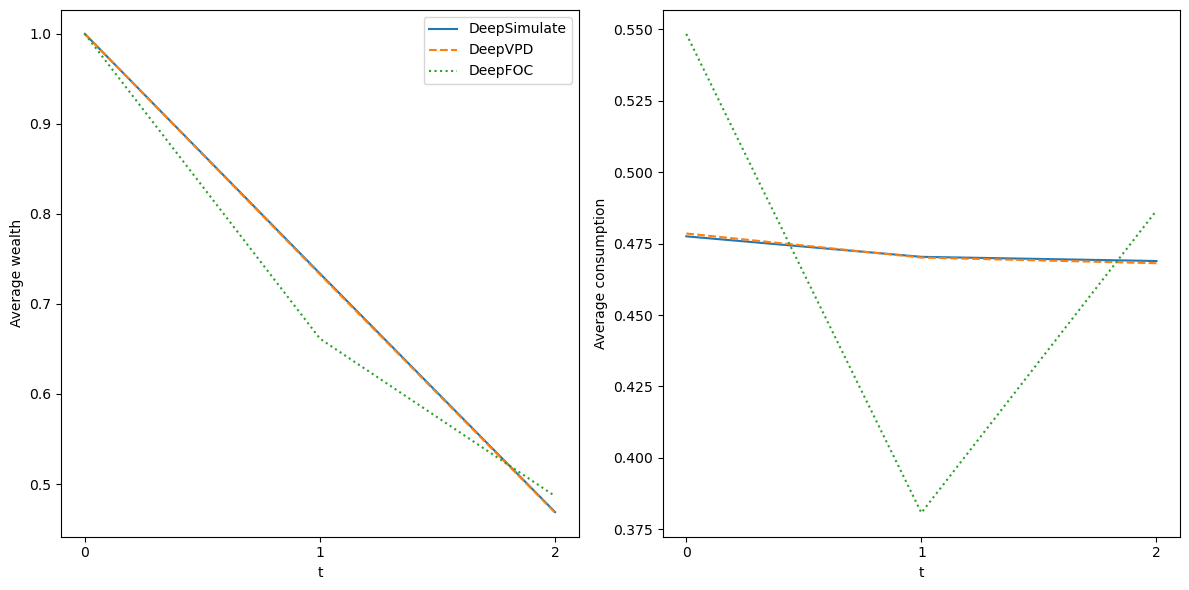

In [26]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

t_range = range(model_DeepFOC.par.T)
avg_wealth_DeepFOC = model_DeepFOC.sim.states[...,0].mean(dim=1).cpu().numpy()
avg_consumption_DeepFOC = model_DeepFOC.sim.outcomes[...,0].mean(dim=1).cpu().numpy()

ax[0].plot(t_range,avg_wealth_DeepSimulate,label='DeepSimulate')
ax[0].plot(t_range,avg_wealth_DeepVPD,label='DeepVPD', linestyle='--')
ax[0].plot(t_range,avg_wealth_DeepFOC,label='DeepFOC', linestyle=':')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Average wealth')
ax[0].set_xticks(t_range)
ax[0].legend()

ax[1].plot(t_range,avg_consumption_DeepSimulate,label='DeepSimulate')
ax[1].plot(t_range,avg_consumption_DeepVPD,label='DeepVPD', linestyle='--')
ax[1].plot(t_range,avg_consumption_DeepFOC,label='DeepFOC', linestyle=':')
ax[1].set_xlabel('t')
ax[1].set_ylabel('Average consumption')
ax[1].set_xticks(t_range)

fig.tight_layout()